In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.inspection import permutation_importance

In [2]:
# Load the dataset
file_path = '/Users/aizixin/Desktop/Processed_E_Pillars_Scaled_Reduced.xlsx'
df = pd.read_excel(file_path)

# Extract features and target variable
X = df.drop(['ROA', 'Instrument'], axis=1)
y = df['ROA']

# Encode categorical variables
label_encoders = {}
for column in X.columns:
    if X[column].dtype == 'object':
        label_encoders[column] = LabelEncoder()
        X[column] = label_encoders[column].fit_transform(X[column])

Fitting 5 folds for each of 162 candidates, totalling 810 fits
Test RMSE: 0.034544119404392164


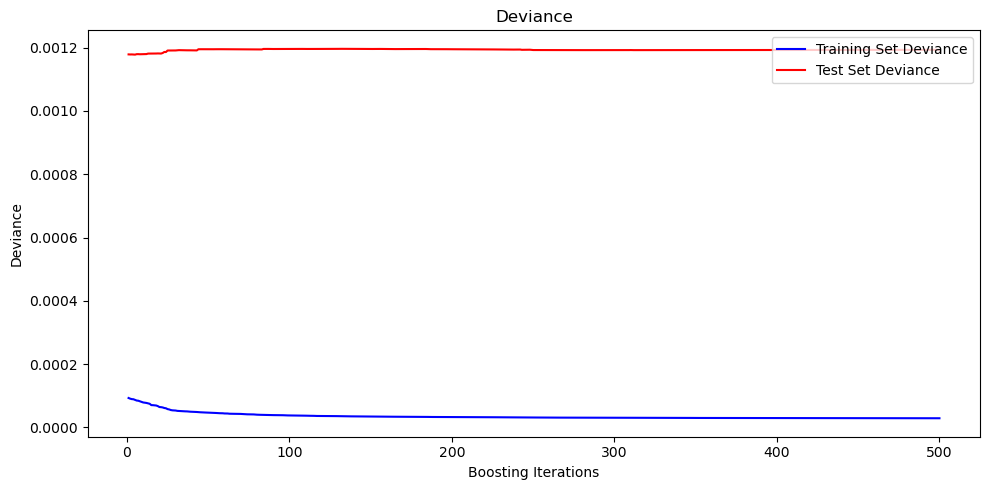

/var/folders/tw/2hxkj_xn3252tw7fdg_sj53m0000gn/T/ipykernel_79483/1015824644.py:59: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


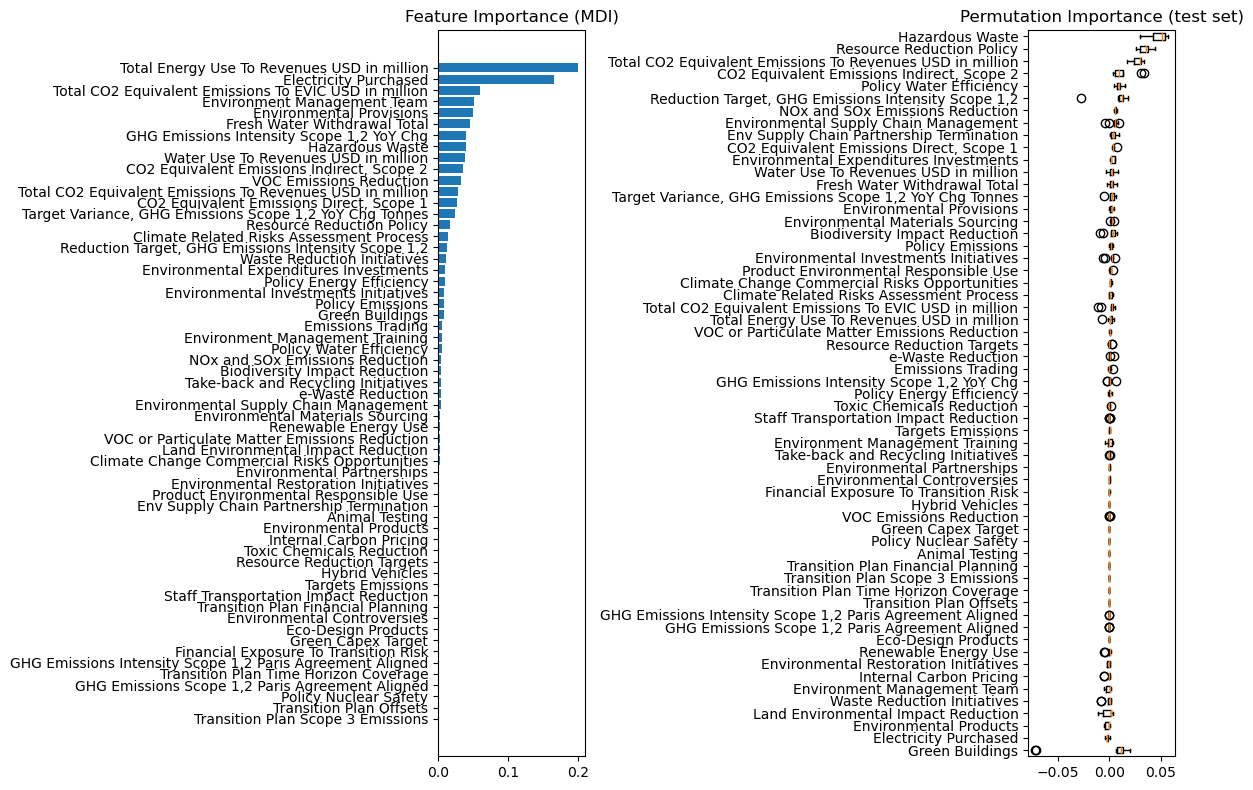

In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=13)

# Define the parameter grid
param_grid = {
    "n_estimators": [100, 200, 500],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 5, 10],
    "learning_rate": [0.01, 0.1, 0.2],
    "loss": ["squared_error", "absolute_error"]
}

# Initialize the regressor
reg = GradientBoostingRegressor(random_state=13)

# RMSE scorer
rmse_scorer = make_scorer(mean_squared_error, squared=False)

# Grid search setup
grid_search = GridSearchCV(estimator=reg, param_grid=param_grid, cv=5, scoring=rmse_scorer, verbose=1)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best parameters and RMSE
best_params = grid_search.best_params_
best_rmse = grid_search.best_score_

# Retrain with best parameters on full training set
best_reg = GradientBoostingRegressor(**best_params, random_state=13)
best_reg.fit(X_train, y_train)

# Test set predictions and MSE
mse = mean_squared_error(y_test, best_reg.predict(X_test))
rmse = np.sqrt(mse)
print("Test RMSE:", rmse)

# Plot training deviance
test_score = np.zeros((best_params['n_estimators'],), dtype=np.float64)
for i, y_pred in enumerate(best_reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(10, 5))
plt.title("Deviance")
plt.plot(np.arange(best_params['n_estimators']) + 1, best_reg.train_score_, 'b-', label="Training Set Deviance")
plt.plot(np.arange(best_params['n_estimators']) + 1, test_score, 'r-', label="Test Set Deviance")
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
plt.tight_layout()
plt.show()

# Feature importance
feature_importance = best_reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5

fig, ax = plt.subplots(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X.columns[sorted_idx])
plt.title('Feature Importance (MDI)')

# Permutation importance
result = permutation_importance(best_reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])
plt.title('Permutation Importance (test set)')
fig.tight_layout()
plt.show()

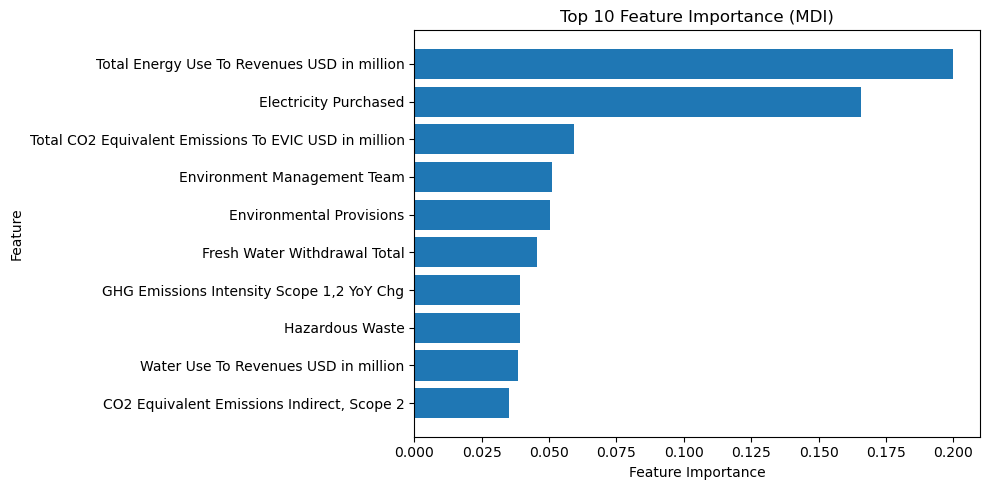

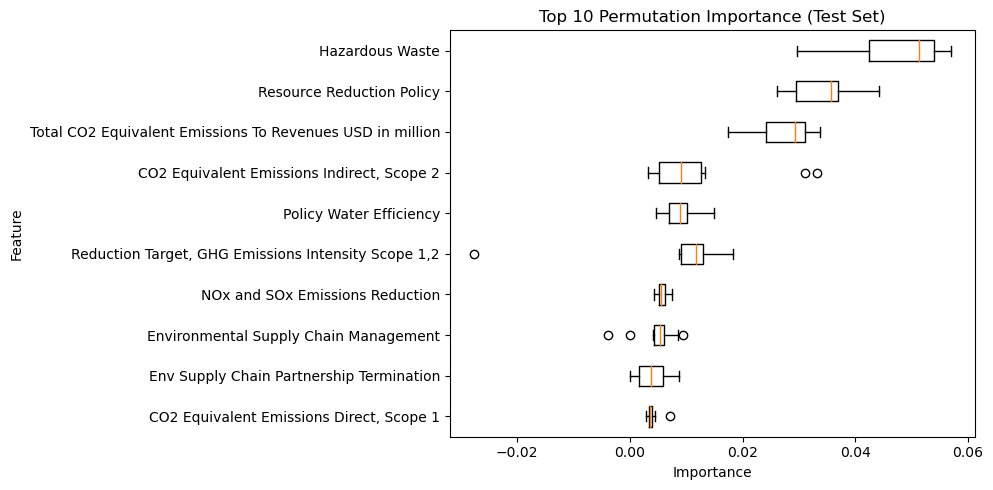

In [4]:
import matplotlib.pyplot as plt

# Feature importance from the model
feature_importance = best_reg.feature_importances_
sorted_idx_mdi = np.argsort(feature_importance)[-10:]  # Get indices of top 10 features

fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Top 10 Feature Importance (MDI)')
plt.barh(range(10), feature_importance[sorted_idx_mdi], align='center')
plt.yticks(range(10), X.columns[sorted_idx_mdi])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# Permutation importance
result = permutation_importance(best_reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
sorted_idx_perm = result.importances_mean.argsort()[-10:]  # Get indices of top 10 features

fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Top 10 Permutation Importance (Test Set)')
plt.boxplot(result.importances[sorted_idx_perm].T, vert=False, labels=X.columns[sorted_idx_perm])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()
